# Preprocessing

In [41]:
import sys
import asyncio

if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor

# Read the CSV file
original_df = pd.read_csv('used_cars.csv')


def preprocessing(df):
    df = df.copy()
    # Per non avere valori nulli nella colonna Service History
    df['Service history'] = df['Service history'].fillna("Unavailable")
    df['Service history'] = df['Service history'].map({'Full': True, 'Unavailable': False})
    # Prendere le colonne categoriche e trasformarle in colonne numeriche facendo il one-hot encoding
    # In python gli alberi di decisione non supportano feature categoriche

    # Prendere solo la marca dell'auto
    df['title'] = df['title'].apply(lambda x: x.split()[0] if isinstance(x, str) else x)

    # Abbiamo provato a togliere proprio title ma predizioni peggiori

    # Eliminare la prima colonna che è l'indice
    df = df.drop(df.columns[0], axis=1)

    # Prendi la cilindrata dell'auto e trasformala in un numero
    df['Engine'] = df['Engine'].str.replace('L', '').astype(float)

    df['Gearbox'] = df['Gearbox'].map({'Automatic': True, 'Manual': False})
    df = df.rename(columns={'Gearbox': 'Gearbox Automatic'})

    df['Emission Class'] = pd.to_numeric(df['Emission Class'].str.replace('Euro ', ''), errors='coerce')

    df['Previous Owners'] = df['Previous Owners'].fillna(0)

    df = df[~df['Body type'].isin(["Combi Van", "Minibus", "Pickup"])]

    df['Fuel type'] = df['Fuel type'].apply(lambda x: {'Petrol Plug-in Hybrid': "Electric/Hybrid", 'Petrol Hybrid': "Electric/Hybrid", 'Diesel Hybrid': "Electric/Hybrid", "Electric": "Electric/Hybrid"}.get(x, x))

    df["Doors"] = df["Doors"].fillna(5)
    df["Seats"] = df["Seats"].fillna(5)

    value_counts = df["title"].value_counts()

    # Filter the values that occur 10 times or more
    values_to_keep = value_counts[value_counts >= 20].index

    # Filter the DataFrame to keep only rows with the desired values
    df = df[df["title"].isin(values_to_keep)]

    df.to_csv('preprocessed_data.csv', index=False)

    df = pd.get_dummies(df, columns=['Fuel type', 'Body type', 'title'])

    # Algoritmi necessitano di valori non nulli
    df = df.dropna()

    return df


preprocessed_df = preprocessing(original_df)
target_column = "Price"
# Prendere le colonne categoriche e trasformarle in colonne numeriche facendo il one-hot encoding
# In python gli alberi di decisione non supportano feature categoriche


print(preprocessed_df)

X = preprocessed_df.drop(target_column, axis=1)
y = preprocessed_df[target_column]

# y_extracted = preprocessed_df[[target_column]]
# scaler = MinMaxScaler()
# y = scaler.fit_transform(y_extracted).ravel()


...

      Price  Mileage(miles)  Registration_Year  Previous Owners  Engine  \
0      6900           70189               2016              3.0     1.4   
1      1495           88585               2008              4.0     1.2   
2       949          137000               2011              0.0     1.4   
3      2395           96731               2010              5.0     1.4   
4      1000           85000               2013              0.0     1.3   
...     ...             ...                ...              ...     ...   
3680   1395           76202               2006              4.0     1.6   
3681   6990          119000               2012              0.0     2.0   
3682   3995          139000               2013              0.0     2.0   
3683   1390          179190               2007              0.0     2.2   
3684   2000           82160               2013              7.0     1.2   

      Gearbox Automatic  Doors  Seats  Emission Class  Service history  ...  \
0                 Fa

Ellipsis

    # Apprendimento supervisionato

In [42]:
def calculate_baseline_score(df, target_column, scoring):
    # Per vedere se la loss del modello è migliore di quella che si potrebbe ottenere con una predizione banale, come media o mediana
    if scoring == "neg_root_mean_squared_error":
        baseline_prediction = df[target_column].mean()
        baseline_error = - (df[target_column] - baseline_prediction).pow(2).mean() ** 0.5
    elif scoring == "neg_mean_absolute_error":
        baseline_prediction = df[target_column].median()
        baseline_error = - (df[target_column] - baseline_prediction).abs().mean()
    else:
        raise ValueError("Invalid scoring metric")

    return baseline_error


def search_hyperparameters(model, param_grid, X, y, cv, scoring):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)

    # scores = cross_val_score(ctf, X, y, cv=cv, scoring=scoring)
    # grid_search.fit implicitamente usa cross_val_score e quindi non abbiamo bisogno di ripeterlo
    # Gli score ottenuti usando cross_val_score con i migliori iperparametri sono già restituiti da grid_search
    scores = grid_search.best_score_
    params = grid_search.best_params_
    print("Scores:", scores)
    print("Best params:", params)

    model_results = {"scores": scores, "params": params, "model": grid_search.best_estimator_}

    return model_results


def performance_comparison(train_results):
    for scoring_metric in train_results:
        fig, ax = plt.subplots(figsize=(10, 6))

        models = list(train_results[scoring_metric].keys())
        scores = [train_results[scoring_metric][model]["scores"] for model in models]

        # Extract mean scores for plotting
        mean_scores = [np.mean(score) for score in scores]

        ax.bar(models, mean_scores, color=['blue', 'green', 'red'])
        plt.gca().invert_yaxis()

        ax.set_title(f'Performance Comparison ({scoring_metric})')
        ax.set_xlabel('Models')
        ax.set_ylabel('Mean Score')

        # Adjust y-axis limits to better visualize negative scores
        # ymin = max(mean_scores) * 1.1 if min(mean_scores) < 0 else max(mean_scores) * 0.9
        # ymax = min(mean_scores) * 1.1 if max(mean_scores) > 0 else min(mean_scores) * 0.9
        # ax.set_ylim([ymin, ymax])
        ax.grid(True)

        # Adding text for each bar
        # for i, v in enumerate(mean_scores):
        #     if v < 0:
        #         ax.text(i, v - (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='top')
        #     else:
        #         ax.text(i, v + (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='bottom')

        plt.savefig(f"performance_comparison_{scoring_metric}.png")


def show_learning_curves(search_results, X_set, y_set, cv):
    # Initialize an empty DataFrame
    variance_df = pd.DataFrame(columns=['Model', 'Train Score Variance', 'Test Score Variance'])

    for scoring_metric in search_results:
        for model_name in search_results[scoring_metric]:
            title = f"Learning Curve ({model_name}, {scoring_metric})"
            estimator = search_results[scoring_metric][model_name].get("model", None)
            if estimator is None:
                continue

            plt.figure(figsize=(10, 6))
            plt.title(title)
            plt.xlabel("Training examples")
            plt.ylabel(scoring_metric)

            train_sizes, train_scores, test_scores = learning_curve(
                estimator, X_set, y_set, cv=cv, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10), scoring=scoring_metric
            )

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            plt.grid()

            plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
            plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
            plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
            plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

            plt.legend(loc="best")
            plt.savefig(f"{title}.png")
            print(f"Saved {title}.png")

            # Calculate the variance of the train and test scores
            train_score_variance = np.var(train_scores, axis=1)[-1]
            test_score_variance = np.var(test_scores, axis=1)[-1]

            # Create a DataFrame with a single row of data
            variance_data = pd.DataFrame([{
                'Model': title,
                'Train Score Variance': train_score_variance,
                'Test Score Variance': test_score_variance,
                'Ratio': test_score_variance / train_score_variance
            }])

            # Append the new data to the DataFrame
            variance_df = pd.concat([variance_df, variance_data], ignore_index=True)
            print(variance_df.head())

    # Print the DataFrame
    return variance_df


# Scelte due metriche di scoring
scorings = ['neg_root_mean_squared_error', 'neg_mean_absolute_error']


## Training dei modelli

In [43]:
results = {s: {"decision_tree": {},
               "random_forest": {},
               "gradient_boosting": {}} for s in scorings}

dtr_param_grid = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    # 'splitter': ['best'],
    # 'max_depth': [None, 10, 20],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

rfr_param_grid = {
    'n_estimators': [100, 200],
    # 'criterion': ["squared_error", "friedman_mse", "poisson"],
    # 'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

gbr_param_grid = {
    'n_estimators': [100, 200],
    # 'loss': ['squared_error', 'huber', 'quantile'],
    # 'learning_rate': [0.01, 0.1, 0.5],
    # 'criterion': ['friedman_mse', 'squared_error'],
    # 'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

# Perform 5-fold cross-validation, repeated 3 times, and print the average score
cv = RepeatedKFold(n_splits=5, n_repeats=1)
# TODO fonty per la grid search fa solo cv=5 che come se fosse n_repeats=1

# Addestrare ogni modello per ogni metrica di scoring
for scoring in scorings[:1]:
    baseline_score = calculate_baseline_score(original_df, target_column, scoring)
    print(f"Baseline for scoring metric {scoring}: ", baseline_score)

    dtr = DecisionTreeRegressor()
    print(f"Training decision tree with scoring metric {scoring}")
    results[scoring]["decision_tree"] = search_hyperparameters(dtr, dtr_param_grid, X, y, cv, scoring)

    rfr = RandomForestRegressor()
    print(f"Training random forest with scoring metric {scoring}")
    results[scoring]["random_forest"] = search_hyperparameters(rfr, rfr_param_grid, X, y, cv, scoring)

    gbr = GradientBoostingRegressor()
    print(f"Training gradient boosted model with scoring metric {scoring}")
    results[scoring]["gradient_boosting"] = search_hyperparameters(gbr, gbr_param_grid, X, y, cv, scoring)

print(results)


Baseline for scoring metric neg_root_mean_squared_error:  -4480.202550929236
Training decision tree with scoring metric neg_root_mean_squared_error
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Scores: -1741.9972918872304
Best params: {'criterion': 'poisson'}
Training random forest with scoring metric neg_root_mean_squared_error
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Scores: -1276.8111936053167
Best params: {'n_estimators': 100}
Training gradient boosted model with scoring metric neg_root_mean_squared_error
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Scores: -1153.2206472236112
Best params: {'n_estimators': 200}
{'neg_root_mean_squared_error': {'decision_tree': {'scores': -1741.9972918872304, 'params': {'criterion': 'poisson'}, 'model': DecisionTreeRegressor(criterion='poisson')}, 'random_forest': {'scores': -1276.8111936053167, 'params': {'n_estimators': 100}, 'model': RandomForestRegressor()}, 'gradient_boosting': {'scores': -1153.22

## Performance Comparison

KeyError: 'scores'

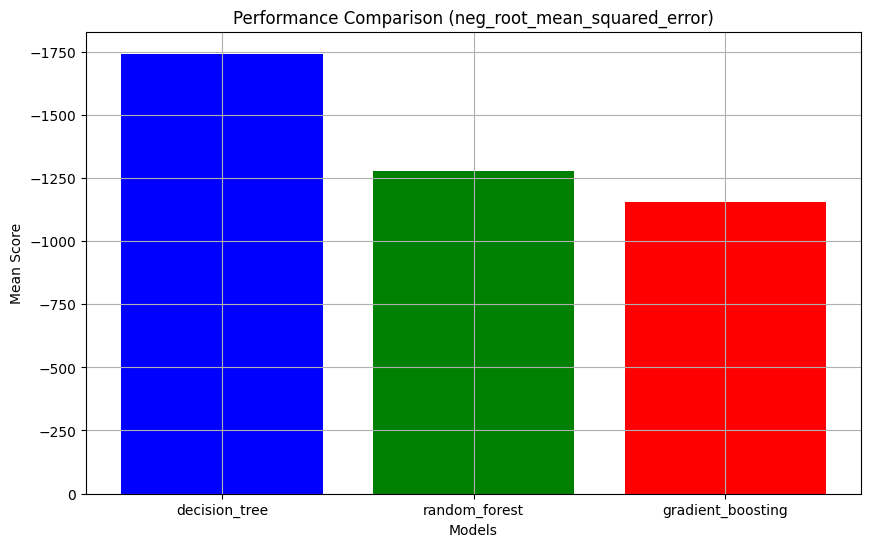

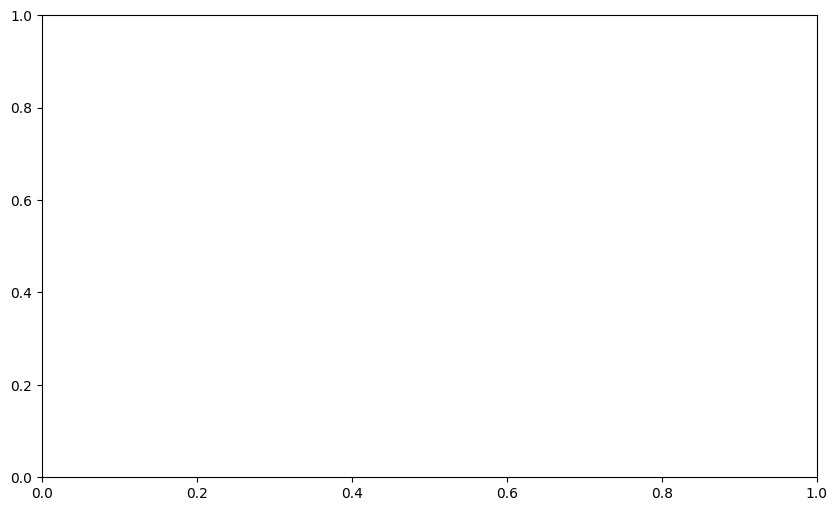

In [44]:
performance_comparison(results)

## Learning Curve

Saved Learning Curve (decision_tree, neg_root_mean_squared_error).png
                                                         Model  \
0  Learning Curve (decision_tree, neg_root_mean_squared_error)   

   Train Score Variance  Test Score Variance         Ratio  
0              0.330313         13873.162297  42000.007498  


C:\Users\Valerio\AppData\Local\Temp\ipykernel_46232\1654488973.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat([variance_df, variance_data], ignore_index=True)


Saved Learning Curve (random_forest, neg_root_mean_squared_error).png
                                                         Model  \
0  Learning Curve (decision_tree, neg_root_mean_squared_error)   
1  Learning Curve (random_forest, neg_root_mean_squared_error)   

   Train Score Variance  Test Score Variance         Ratio  
0              0.330313         13873.162297  42000.007498  
1            125.529861          8448.515269     67.302833  
Saved Learning Curve (gradient_boosting, neg_root_mean_squared_error).png
                                                             Model  \
0      Learning Curve (decision_tree, neg_root_mean_squared_error)   
1      Learning Curve (random_forest, neg_root_mean_squared_error)   
2  Learning Curve (gradient_boosting, neg_root_mean_squared_error)   

   Train Score Variance  Test Score Variance         Ratio  
0              0.330313         13873.162297  42000.007498  
1            125.529861          8448.515269     67.302833  
2         

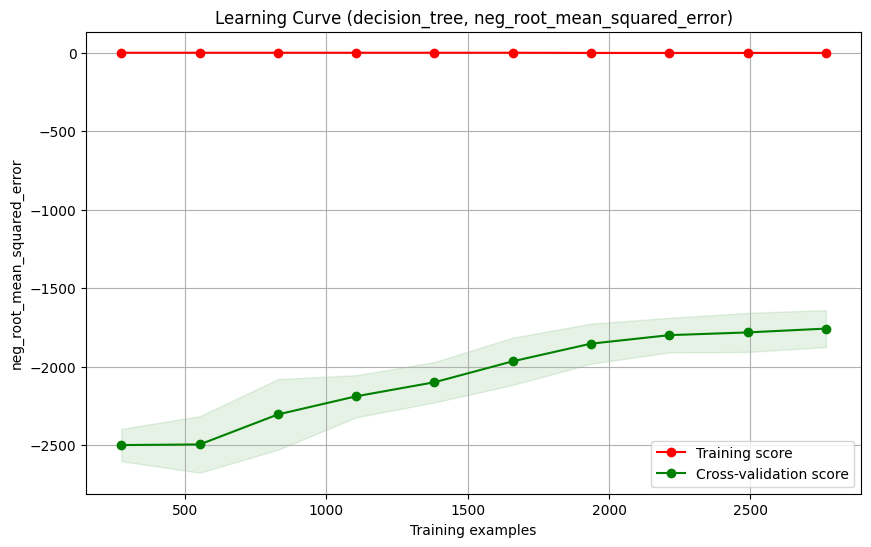

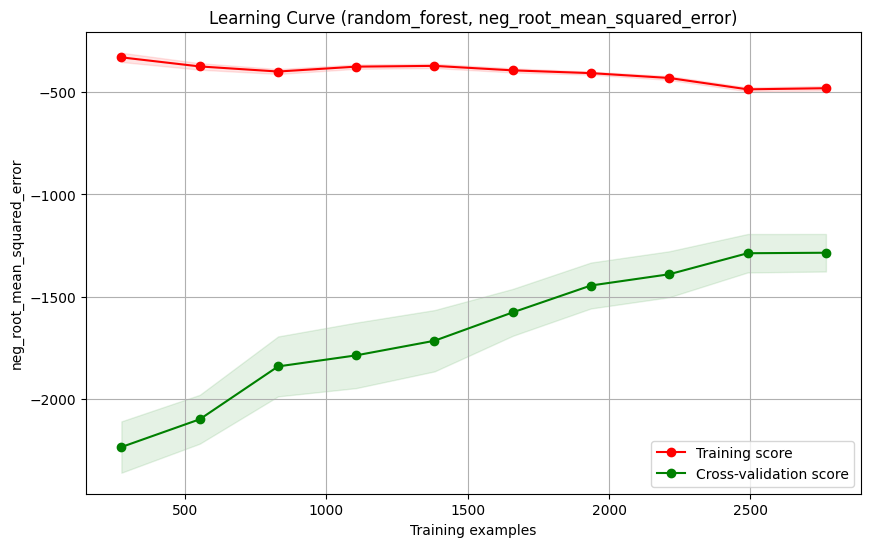

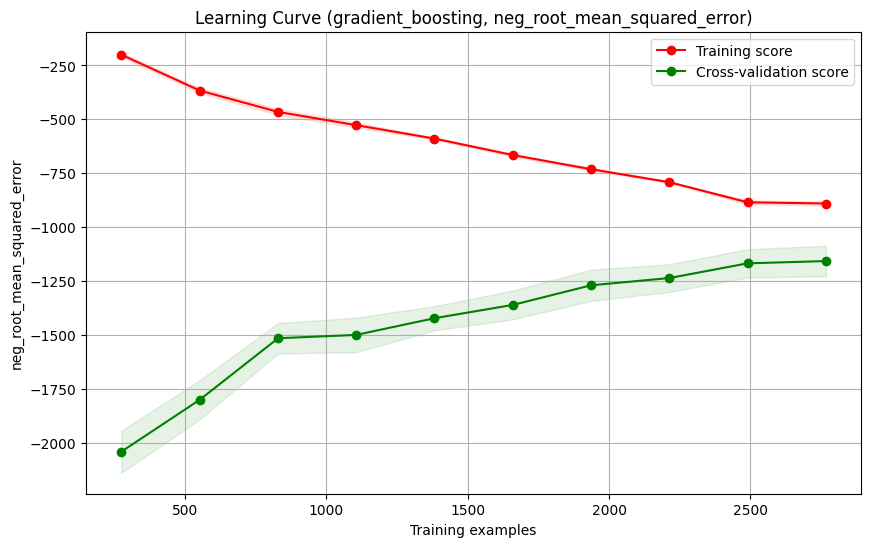

In [46]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
var_df = show_learning_curves(results, X, y, cv)
print(var_df.head())

# Apprendimento non supervisionato

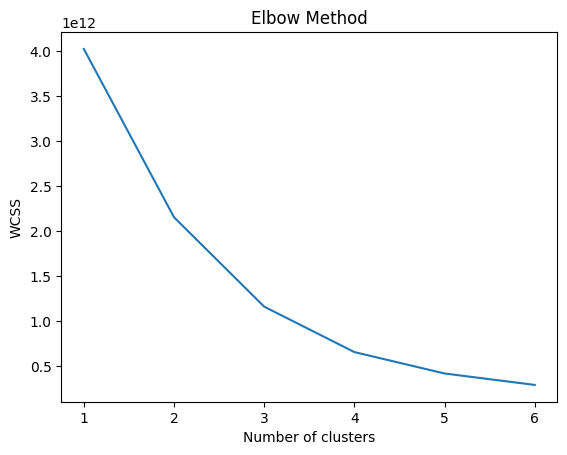

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calcola la somma dei quadrati interni per diversi numeri di cluster
wcss = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Crea un grafico con il numero di cluster sull'asse x e WCSS sull'asse y
plt.plot(range(1, 7), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Somma delle distanze quadrate interne')
plt.show()


In [46]:
n_clusters = 3  # o 4???

kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Addestra il modello sui dati
kmeans.fit(X)

# Utilizza il modello per fare previsioni
predictions = kmeans.predict(X)

# Aggiungi le previsioni al DataFrame
preprocessed_df['Cluster'] = predictions

...

KeyboardInterrupt: 

# Riduzione della dimensionalità

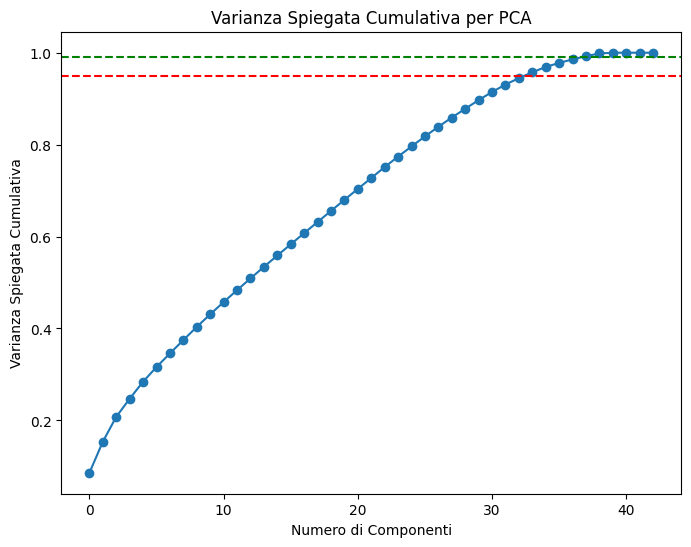

Numero di componenti che spiegano almeno il 95% della varianza: 34


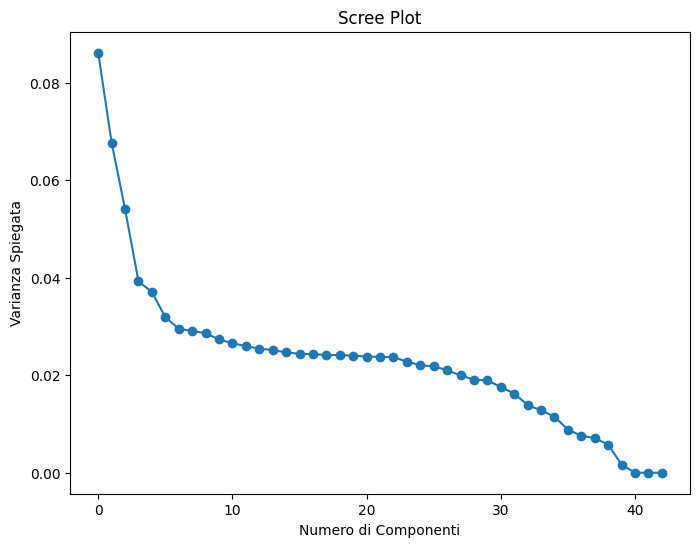

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Supponiamo che 'preprocessed_df' sia il dataframe preprocessato
# Standardizzare i dati
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Applicare PCA senza ridurre il numero di componenti
pca = PCA()
pca.fit(scaled_X)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata Cumulativa per PCA')
plt.axhline(y=0.95, color='r', linestyle='--')  # Linea di soglia al 95%
plt.axhline(y=0.99, color='g', linestyle='--')  # Linea di soglia al 99%
plt.show()

num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Numero di componenti che spiegano almeno il 95% della varianza: {num_components_95}')

plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata')
plt.title('Scree Plot')
plt.show()


Si è deciso di prendere 8 componenti principali

In [60]:
# Applicare PCA con 8 componenti
n_components = 7
pca = PCA(n_components)
pca_data = pca.fit_transform(scaled_X)

# Creare un DataFrame con i dati PCA
pca_X = pd.DataFrame(data=pca_data, columns=[f'PC{i}' for i in range(1, n_components + 1)])

print(pca_X)


           PC1       PC2       PC3       PC4       PC5       PC6       PC7
0     0.106763 -2.059607  0.151091 -1.798323 -2.450501 -0.830347 -0.747684
1    -1.600660  1.290021  0.939902  0.222966  0.046483  1.174867 -0.056061
2    -1.272869  0.189262  0.933198 -0.040353  0.638393 -0.091621 -1.950162
3    -1.623010  2.470540 -0.332179  0.358250 -1.215040 -0.097948 -1.720994
4    -0.294024 -1.203293  0.479087 -1.049612 -0.851477  0.408123  0.314293
...        ...       ...       ...       ...       ...       ...       ...
3454 -1.114693  0.698851  1.735741 -0.144648  0.765211  0.867955  0.045495
3455  1.535084  1.042988 -0.757148 -0.545956  0.974658  0.032226 -0.599228
3456  3.393417  0.259049 -0.952304 -1.252763  0.679312 -0.870968 -0.055360
3457  2.924928  0.083033  2.491672 -0.004938 -2.062683 -0.144197  0.486997
3458 -1.648868 -0.012357  1.163364 -0.399419 -0.072118  0.290789  0.196690

[3459 rows x 7 columns]


Si riprova a fare apprendimento supervisionato con i dati PCA

In [63]:

results_pca = {s: {"decision_tree": {"scores": None, "params": None},
                   "random_forest": {"scores": None, "params": None},
                   "gradient_boosting": {"scores": None, "params": None}} for s in scorings}

cv = RepeatedKFold(n_splits=5, n_repeats=1)
# TODO fonty per la grid search fa solo cv=5 che come se fosse n_repeats=1

# Addestrare ogni modello per ogni metrica di scoring
for scoring in scorings[:1]:
    baseline_score = calculate_baseline_score(original_df, target_column, scoring)
    print(f"Baseline for scoring metric {scoring}: ", baseline_score)

    dtr = DecisionTreeRegressor()
    print(f"Training decision tree with scoring metric {scoring}")
    results_pca[scoring]["decision_tree"] = search_hyperparameters(dtr, dtr_param_grid, pca_X, y, cv, scoring)

    rfr = RandomForestRegressor()
    print(f"Training random forest with scoring metric {scoring}")
    results_pca[scoring]["random_forest"] = search_hyperparameters(rfr, rfr_param_grid, pca_X, y, cv, scoring)

    gbr = GradientBoostingRegressor()
    print(f"Training gradient boosted model with scoring metric {scoring}")
    results_pca[scoring]["gradient_boosting"] = search_hyperparameters(gbr, gbr_param_grid, pca_X, y, cv, scoring)

print(results_pca)


Baseline for scoring metric neg_root_mean_squared_error:  -4480.202550929236
Training decision tree with scoring metric neg_root_mean_squared_error
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Scores: -2167.9687787163703
Best params: {'criterion': 'squared_error'}
Training random forest with scoring metric neg_root_mean_squared_error
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Scores: -1666.3459349359632
Best params: {'n_estimators': 100}
Training gradient boosted model with scoring metric neg_root_mean_squared_error
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Scores: -1744.6835158494202
Best params: {'n_estimators': 200}
{'neg_root_mean_squared_error': {'decision_tree': {'scores': -2167.9687787163703, 'params': {'criterion': 'squared_error'}, 'model': DecisionTreeRegressor()}, 'random_forest': {'scores': -1666.3459349359632, 'params': {'n_estimators': 100}, 'model': RandomForestRegressor()}, 'gradient_boosting': {'scores': -1744.683515849

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

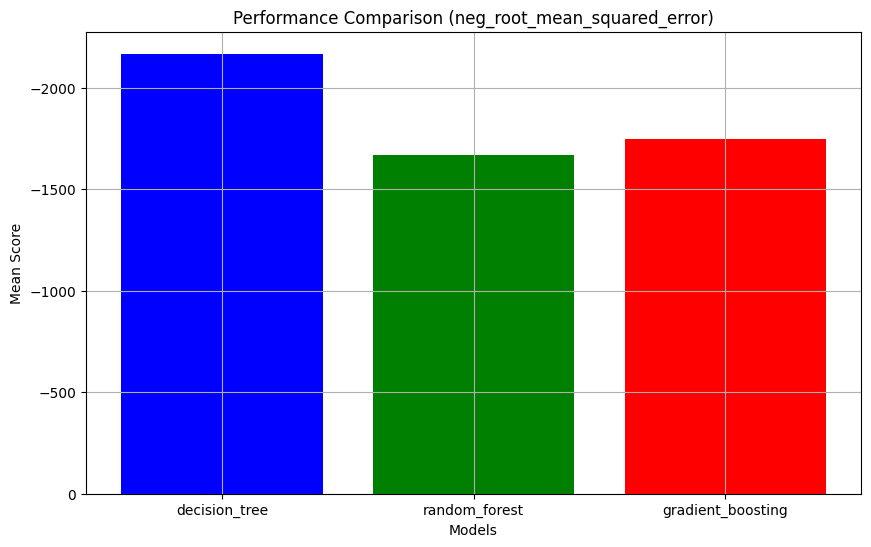

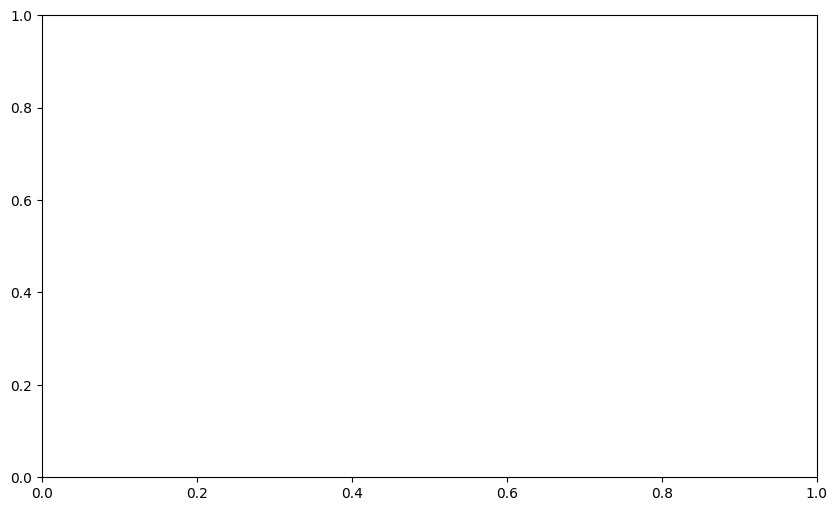

In [64]:
performance_comparison(results_pca)

Saved Learning Curve (decision_tree, neg_root_mean_squared_error).png
                                                         Model  \
0  Learning Curve (decision_tree, neg_root_mean_squared_error)   

   Train Score Variance  Test Score Variance          Ratio  
0              0.330594         47958.289024  145066.988847  


C:\Users\Valerio\AppData\Local\Temp\ipykernel_46232\1654488973.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat([variance_df, variance_data], ignore_index=True)


Saved Learning Curve (random_forest, neg_root_mean_squared_error).png
                                                         Model  \
0  Learning Curve (decision_tree, neg_root_mean_squared_error)   
1  Learning Curve (random_forest, neg_root_mean_squared_error)   

   Train Score Variance  Test Score Variance          Ratio  
0              0.330594         47958.289024  145066.988847  
1            113.071100         17532.705310     155.059120  
Saved Learning Curve (gradient_boosting, neg_root_mean_squared_error).png
                                                             Model  \
0      Learning Curve (decision_tree, neg_root_mean_squared_error)   
1      Learning Curve (random_forest, neg_root_mean_squared_error)   
2  Learning Curve (gradient_boosting, neg_root_mean_squared_error)   

   Train Score Variance  Test Score Variance          Ratio  
0              0.330594         47958.289024  145066.988847  
1            113.071100         17532.705310     155.059120  
2   

,Model,Train Score Variance,Test Score Variance,Ratio
0,"Learning Curve (decision_tree, neg_root_mean_squared_error)",0.330594,47958.289024,145066.988847
1,"Learning Curve (random_forest, neg_root_mean_squared_error)",113.071100,17532.705310,155.059120
2,"Learning Curve (gradient_boosting, neg_root_mean_squared_error)",391.664034,11548.377060,29.485416


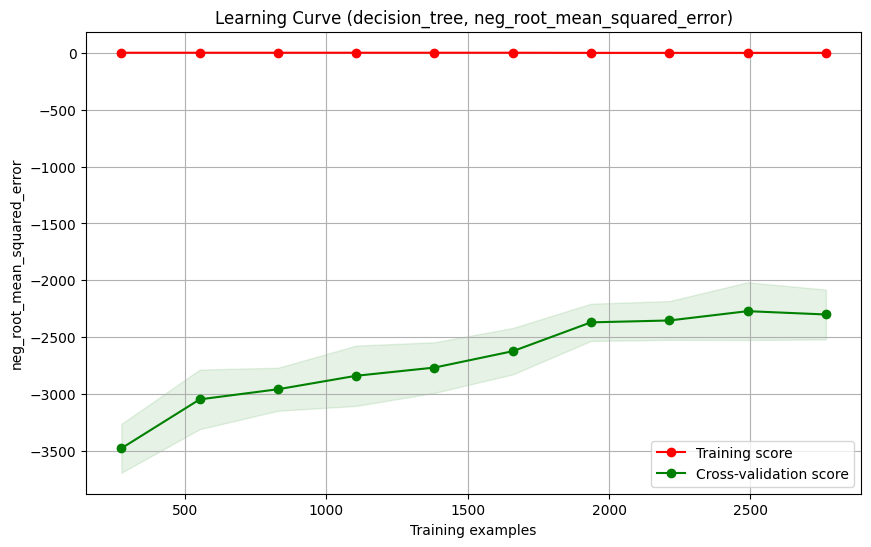

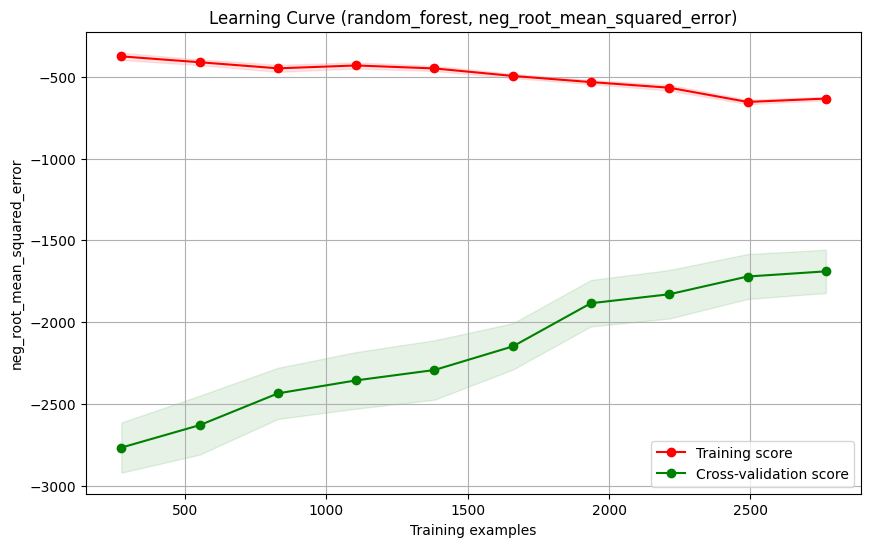

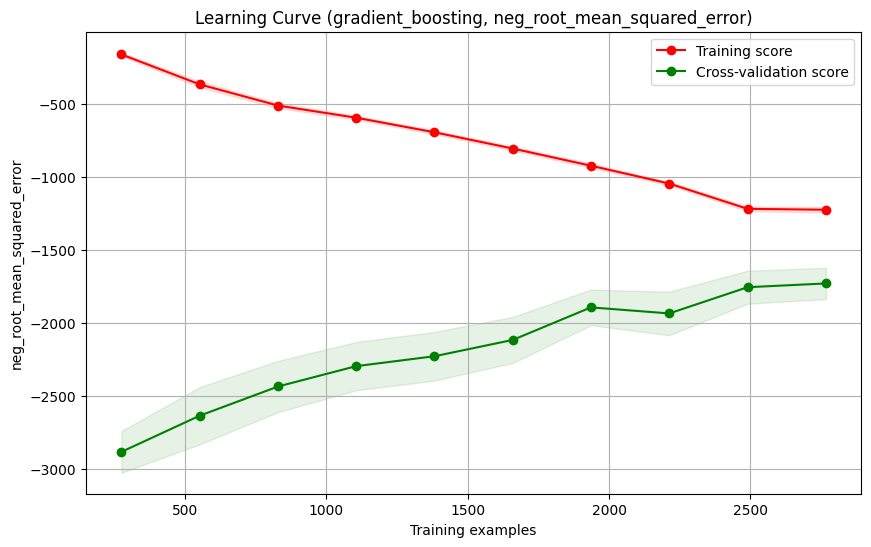

In [65]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
show_learning_curves(results_pca, pca_X, y, cv)

# Riassunto documentazione

In questo notebook abbiamo eseguito un'analisi dei dati su un dataset di auto usate, con l'obiettivo di prevedere il prezzo di vendita di un'auto in base alle sue caratteristiche. Abbiamo eseguito un'analisi esplorativa dei dati, effettuato il preprocessing dei dati, addestrato modelli di apprendimento supervisionato e non supervisionato, e ridotto la dimensionalità dei dati utilizzando la PCA.

Abbiamo confrontato le prestazioni dei modelli addestrati utilizzando diverse metriche di scoring e visualizzato le curve di apprendimento per valutare il trade-off tra bias e varianza. Infine, abbiamo esaminato l'impatto della riduzione della dimensionalità sui modelli di apprendimento supervisionato.

I risultati ottenuti mostrano che i modelli di Random Forest e Gradient Boosted Trees hanno prestazioni migliori rispetto al Decision Tree, con il Gradient Boosted Trees che fornisce i risultati migliori in termini di metriche di scoring. Inoltre, la riduzione della dimensionalità tramite PCA ha portato a una riduzione delle prestazioni dei modelli di apprendimento supervisionato, con un aumento della varianza e una diminuzione della capacità predittiva.

In futuro, potremmo esplorare ulteriori tecniche di preprocessing dei dati, addestrare modelli più complessi e ottimizzare ulteriormente gli iperparametri per migliorare le prestazioni dei modelli. Inoltre, potremmo esplorare altre tecniche di riduzione della dimensionalità e valutare il loro impatto sui modelli di apprendimento supervisionato.

# Uso della base di conoscenza nel nostro progetto

Fatto macchina
Fatto marca che collega title e marca

Regola per la classe di economicità

Ibrida a classe euro



# Da albero a prolog

In [17]:
dtr.fit(X, y)

DecisionTreeRegressor(random_state=42)

In [33]:
from sklearn.tree import _tree


def extract_tree_structure(tree, feature_names):
    tree_ = tree.tree_
    feature_names = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if ({name} <= {threshold:.2f}) {{")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}}} else {{")
            recurse(tree_.children_right[node], depth + 1)
            print(f"{indent}}}")
        else:
            print(f"{indent}return {tree_.value[node]}")

    recurse(0, 0)


# Extract tree structure
def tree_to_prolog(regressor, node_id=0, parent_id=None):
    base_code = """
predict(Features, Prediction) :-
    traverse_tree(0, Features, Prediction).

% Passo base
traverse_tree(NodeID, _, Prediction) :-
    leaf(NodeID, Prediction).

% Passo ricorsivo
traverse_tree(NodeID, Features, Prediction) :-
    node(NodeID, FeatureIndex, Threshold, LeftChild, RightChild, _),
    nth0(FeatureIndex, Features, FeatureValue),
    (FeatureValue =< Threshold ->
        traverse_tree(LeftChild, Features, Prediction)
    ;
        traverse_tree(RightChild, Features, Prediction)
    ).

"""

    result = ""
    # Check if it's a leaf node
    if regressor.tree_.children_left[node_id] == -1:
        # Leaf node
        value = regressor.tree_.value[node_id][0, 0]  # Assuming single target value
        result += f"leaf({node_id}, {value}).\n"
    else:
        # Decision node
        feature = regressor.tree_.feature[node_id]
        threshold = regressor.tree_.threshold[node_id]
        left_child = regressor.tree_.children_left[node_id]
        right_child = regressor.tree_.children_right[node_id]
        result += f"node({node_id}, {feature}, {threshold}, {left_child}, {right_child}, _).\n"
        # Recursively add left and right children
        result += tree_to_prolog(regressor, left_child, node_id)
        result += tree_to_prolog(regressor, right_child, node_id)
    return base_code + result


prl = tree_to_prolog(dtr)
prl = "\n".join(sorted(prl.split("\n")))
print(prl)


leaf(1003, 2950.0).
leaf(1004, 2945.0).
leaf(1006, 2999.0).
leaf(1007, 3000.0).
leaf(1008, 3199.0).
leaf(1009, 3295.0).
leaf(1011, 2250.0).
leaf(1012, 2485.0).
leaf(1013, 3995.0).
leaf(1015, 1600.0).
leaf(1016, 1990.0).
leaf(1018, 3949.0).
leaf(1019, 3995.0).
leaf(102, 950.0).
leaf(1020, 4550.0).
leaf(1021, 4594.0).
leaf(1025, 2395.0).
leaf(1026, 2499.0).
leaf(1030, 2300.0).
leaf(1033, 1995.0).
leaf(1034, 1999.0).
leaf(1036, 2199.0).
leaf(1037, 2100.0).
leaf(1038, 1990.0).
leaf(1039, 2495.0).
leaf(1040, 945.0).
leaf(1041, 4950.0).
leaf(1043, 3290.0).
leaf(1044, 5695.0).
leaf(1045, 5999.0).
leaf(1048, 4995.0).
leaf(1051, 4500.0).
leaf(1052, 4449.0).
leaf(1053, 4670.0).
leaf(1056, 1950.0).
leaf(1058, 2995.0).
leaf(1059, 2795.0).
leaf(1062, 2795.0).
leaf(1063, 2350.0).
leaf(1067, 3230.0).
leaf(1068, 3499.0).
leaf(1071, 3940.0).
leaf(1072, 3995.0).
leaf(1073, 3690.0).
leaf(1076, 4785.0).
leaf(1077, 4795.0).
leaf(1078, 3696.0).
leaf(1080, 5450.0).
leaf(1081, 4990.0).
leaf(1085, 4599.0).
le

In [36]:

print(list(X.iloc[0].values.astype(float)))
dtr.predict([X.iloc[0].values])

[70189.0, 2016.0, 3.0, 1.4, 0.0, 5.0, 5.0, 6.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([6900.])